In [1]:
import numpy as np
from cmdstanpy import CmdStanModel
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Priors [0-4 pts]
- Is it explained why particular priors for parameters were selected [1 pt]
- Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]
- Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]
- How prior parameters were selected [1 pt]

In [43]:
model_1_ppc = CmdStanModel(stan_file='stan/model_2_ppc.stan')

09:49:27 - cmdstanpy - INFO - compiling stan file /workspace/F1_bayesian/stan/model_2_ppc.stan to exe file /workspace/F1_bayesian/stan/model_2_ppc
09:50:03 - cmdstanpy - INFO - compiled model executable: /workspace/F1_bayesian/stan/model_2_ppc


In [59]:
model_1_ppc_sim = model_1_ppc.sample(data={'sigma':0.8, 'drive_rating': 2.5, 'avg_pos':  -2.5}, iter_warmup=1, fixed_param=True, seed=10062022)
df_ppc_sim = model_1_ppc_sim.draws_pd()
df_ppc_sim

11:52:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:52:06 - cmdstanpy - INFO - CmdStan done processing.


,chain__,iter__,draw__,lp__,accept_stat__,engine,constructor,alpha_driver,beta_avg_pos,theta,y_ppc
0,1.0,1.0,1.0,0.0,0.0,1.021630,0.217896,0.518850,0.802796,0.112587,2.0
1,1.0,2.0,2.0,0.0,0.0,0.506450,-0.719667,0.858580,1.201730,0.004660,0.0
2,1.0,3.0,3.0,0.0,0.0,-0.017876,-0.141806,0.139802,1.782740,0.006922,0.0
3,1.0,4.0,4.0,0.0,0.0,-0.349485,-0.446207,1.347840,0.124769,0.011237,0.0
4,1.0,5.0,5.0,0.0,0.0,-0.203628,0.068063,1.440530,0.325339,0.010454,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3995,4.0,996.0,3996.0,0.0,0.0,-1.218360,0.663735,0.753395,0.258401,0.043767,0.0
3996,4.0,997.0,3997.0,0.0,0.0,-1.052820,1.210300,0.248586,1.468330,0.015753,0.0
3997,4.0,998.0,3998.0,0.0,0.0,0.911691,-0.667599,1.158970,1.255010,0.003046,0.0
3998,4.0,999.0,3999.0,0.0,0.0,1.094630,0.301108,1.020680,0.636097,0.060301,0.0


## The Prior tests were prepared for the best, average, and weakest driver.

### The driver with the best results.

09:39:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:39:52 - cmdstanpy - INFO - CmdStan done processing.


09:39:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:39:52 - cmdstanpy - INFO - CmdStan done processing.


09:39:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:39:53 - cmdstanpy - INFO - CmdStan done processing.


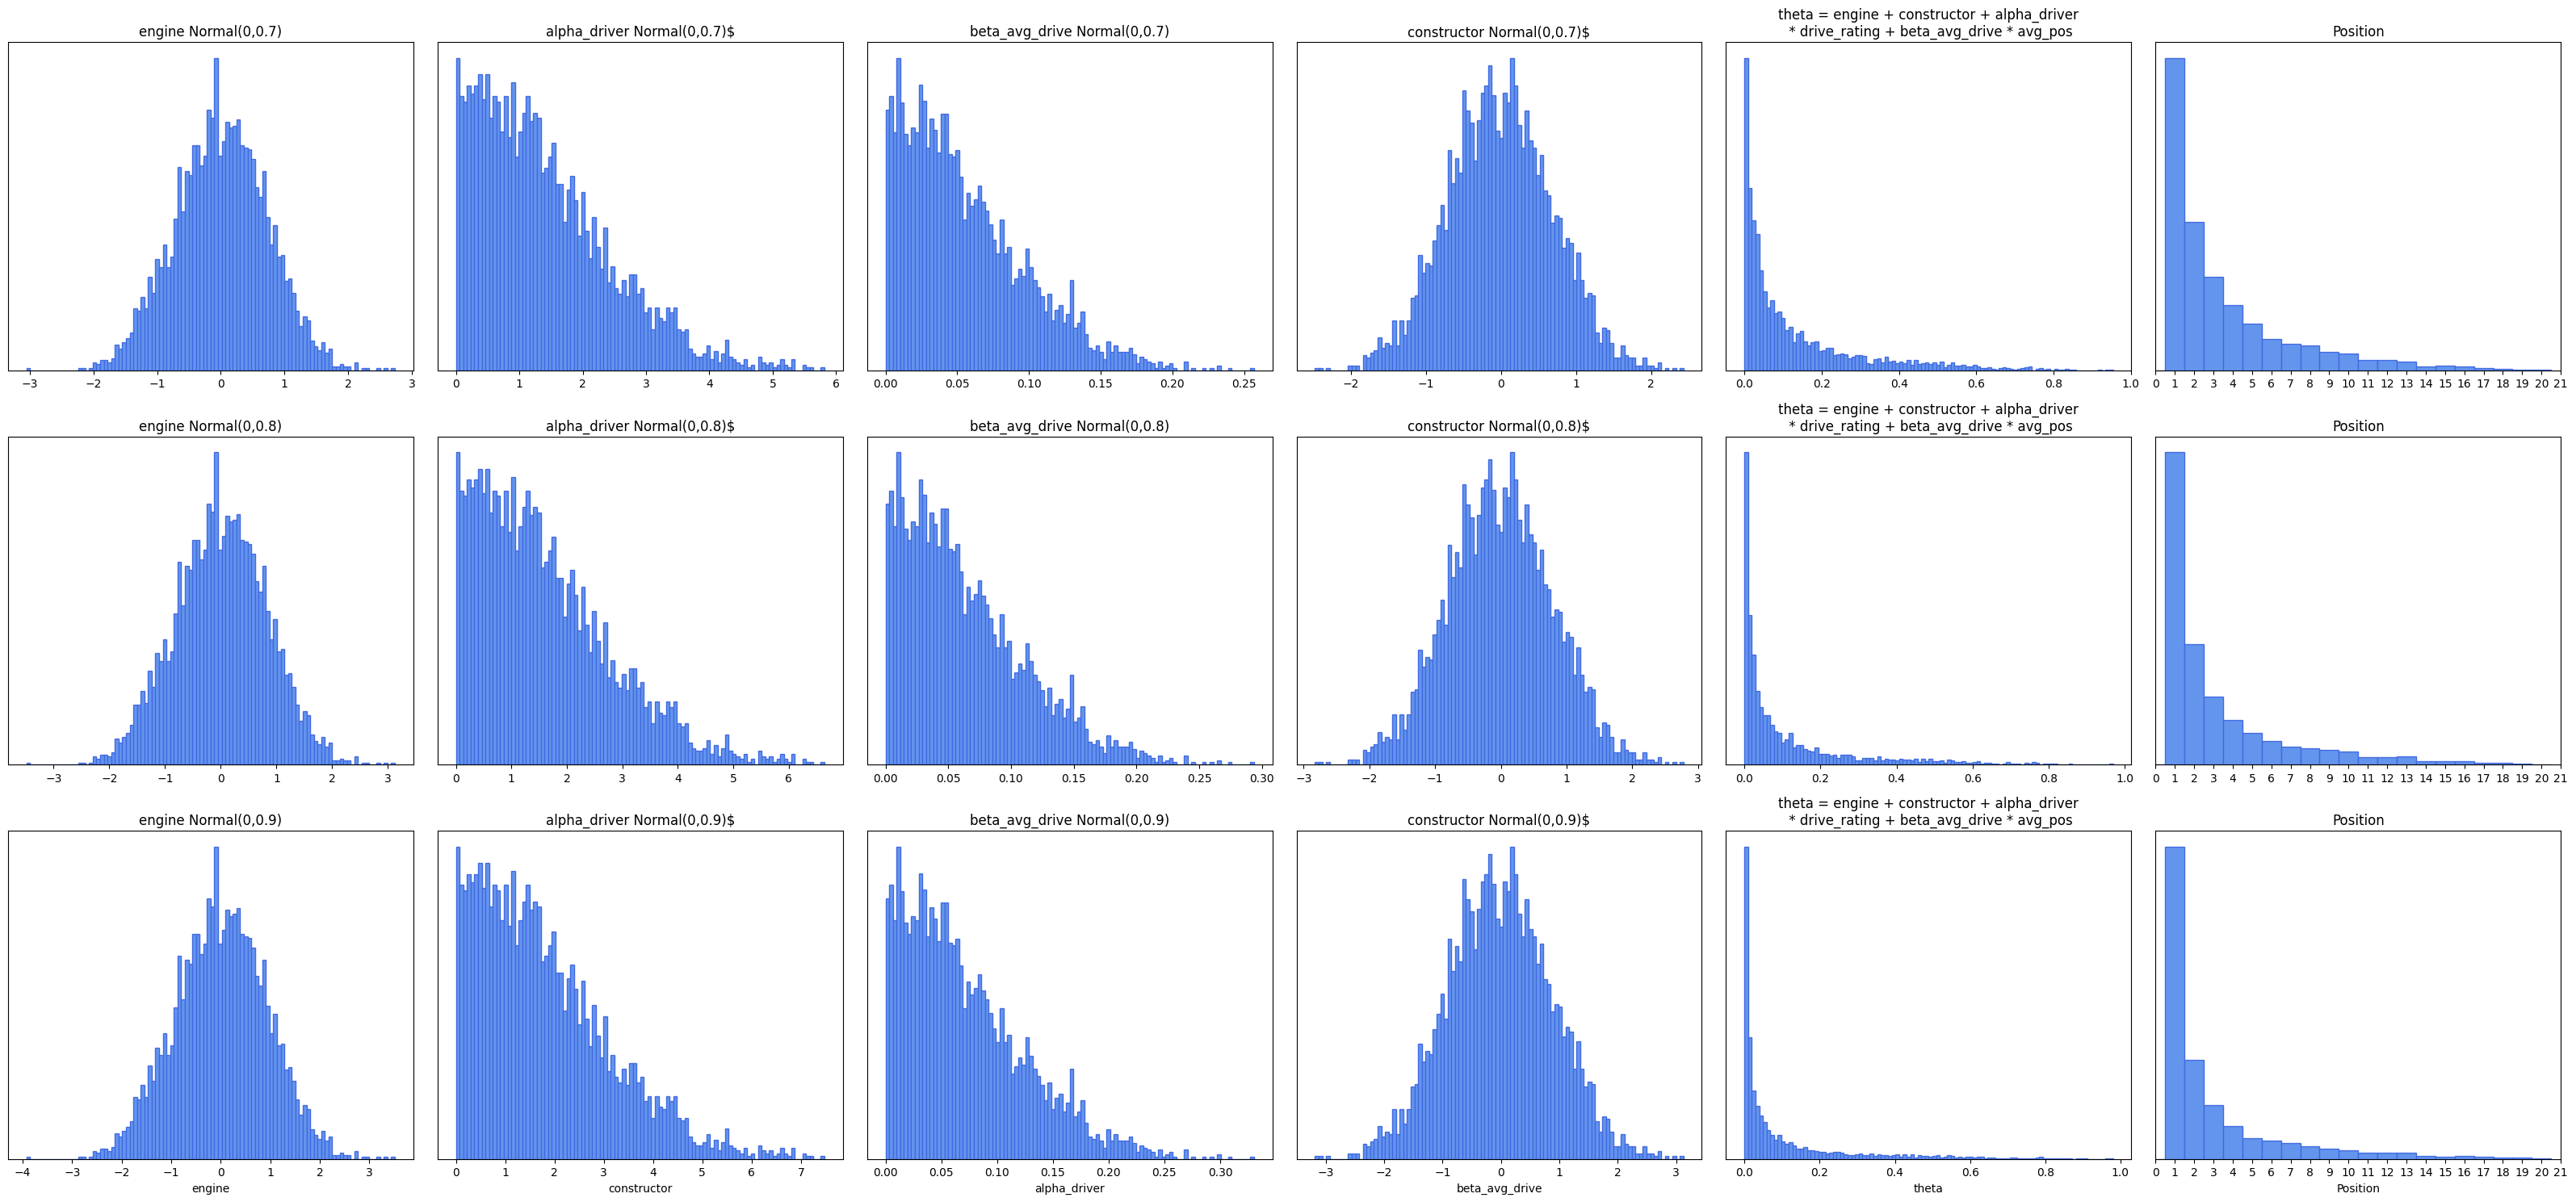

In [40]:
fig, axes = plt.subplots(3, 6, figsize=(8*4, 15))

sigmas = [0.7, 0.8, 0.9]

for s_i in range(3):
    sigma = {'sigma':sigmas[s_i], 'drive_rating': 2.5, 'avg_pos':  -2.5} # Standard scaler for driver rating ang avg_pos
    model_1_ppc_sim = model_1_ppc.sample(data=sigma, iter_warmup=1, fixed_param=True, seed=10062022)
    axes[s_i, 0].hist(model_1_ppc_sim.stan_variable('engine').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 0].set_yticks([])
    axes[s_i, 0].set_title(f'engine Normal(0,{sigmas[s_i]})')


    axes[s_i, 1].hist(model_1_ppc_sim.stan_variable('alpha_driver').flatten() * 2.5, bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 1].set_yticks([])
    axes[s_i, 1].set_title(f'alpha_driver Normal(0,{sigmas[s_i]})$')

    axes[s_i, 2].hist(model_1_ppc_sim.stan_variable('beta_avg_pos').flatten() *0.1, bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 2].set_yticks([])
    axes[s_i, 2].set_title(f'beta_avg_drive Normal(0,{sigmas[s_i]})')


    axes[s_i, 3].hist(model_1_ppc_sim.stan_variable('constructor').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 3].set_yticks([])
    axes[s_i, 3].set_title(f'constructor Normal(0,{sigmas[s_i]})$')


    axes[s_i, 4].hist(model_1_ppc_sim.stan_variable('theta').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 4].set_yticks([])
    axes[s_i, 4].set_title(f'theta = engine + constructor + alpha_driver\n * drive_rating + beta_avg_drive * avg_pos')

    # pos_min = 1, pos_max = 20
    n_bins = np.arange(22) - 0.5
    axes[s_i, 5].hist(model_1_ppc_sim.stan_variable('y_ppc').flatten()+1, bins=n_bins, rwidth=1, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 5].set_xticks(range(22))
    axes[s_i, 5].set_xlim([0, 21])
    axes[s_i, 5].set_yticks([])
    axes[s_i, 5].set_title('Position')

axes[2, 0].set_xlabel('engine')
axes[2, 1].set_xlabel('constructor')
axes[2, 2].set_xlabel('alpha_driver')
axes[2, 3].set_xlabel('beta_avg_drive')
axes[2, 4].set_xlabel('theta')
axes[2, 5].set_xlabel('Position')

fig.tight_layout()
plt.show()

### An average driver from the middle of the field.

09:39:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:39:28 - cmdstanpy - INFO - CmdStan done processing.


09:39:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:39:29 - cmdstanpy - INFO - CmdStan done processing.


09:39:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:39:29 - cmdstanpy - INFO - CmdStan done processing.


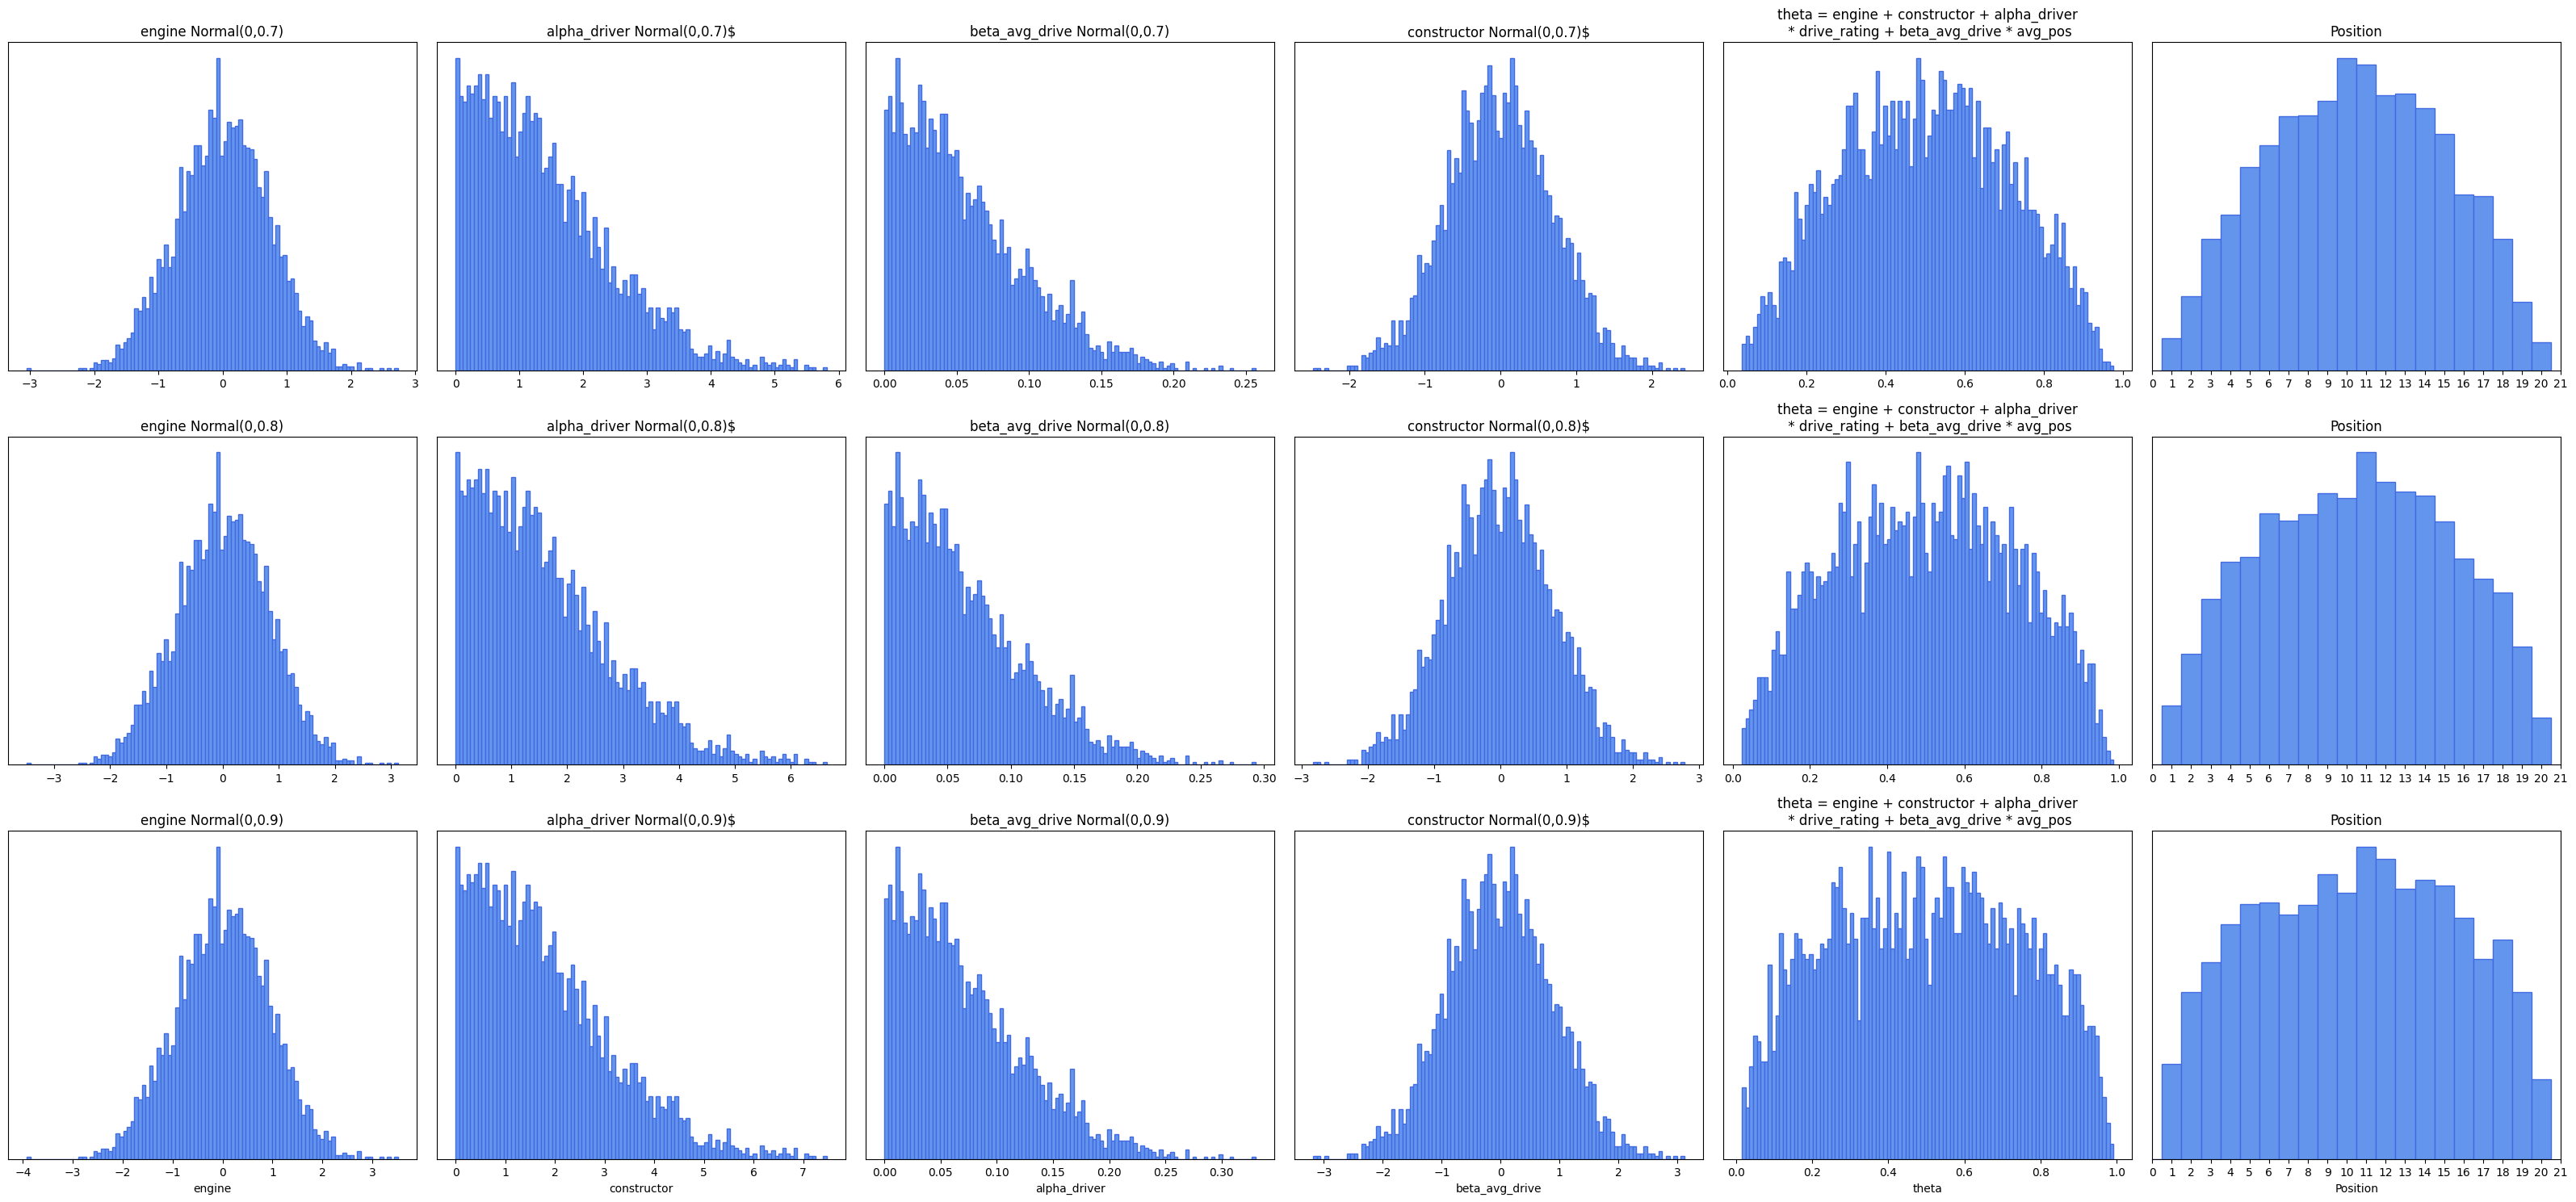

In [39]:
fig, axes = plt.subplots(3, 6, figsize=(8*4, 15))

sigmas = [0.7, 0.8, 0.9]

for s_i in range(3):
    sigma = {'sigma':sigmas[s_i], 'drive_rating': 0, 'avg_pos':  0} # Standard scaler for driver rating ang avg_pos
    model_1_ppc_sim = model_1_ppc.sample(data=sigma, iter_warmup=1, fixed_param=True, seed=10062022)
    axes[s_i, 0].hist(model_1_ppc_sim.stan_variable('engine').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 0].set_yticks([])
    axes[s_i, 0].set_title(f'engine Normal(0,{sigmas[s_i]})')


    axes[s_i, 1].hist(model_1_ppc_sim.stan_variable('alpha_driver').flatten() * 2.5, bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 1].set_yticks([])
    axes[s_i, 1].set_title(f'alpha_driver Normal(0,{sigmas[s_i]})$')

    axes[s_i, 2].hist(model_1_ppc_sim.stan_variable('beta_avg_pos').flatten() *0.1, bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 2].set_yticks([])
    axes[s_i, 2].set_title(f'beta_avg_drive Normal(0,{sigmas[s_i]})')


    axes[s_i, 3].hist(model_1_ppc_sim.stan_variable('constructor').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 3].set_yticks([])
    axes[s_i, 3].set_title(f'constructor Normal(0,{sigmas[s_i]})$')


    axes[s_i, 4].hist(model_1_ppc_sim.stan_variable('theta').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 4].set_yticks([])
    axes[s_i, 4].set_title(f'theta = engine + constructor + alpha_driver\n * drive_rating + beta_avg_drive * avg_pos')

    # pos_min = 1, pos_max = 20
    n_bins = np.arange(22) - 0.5
    axes[s_i, 5].hist(model_1_ppc_sim.stan_variable('y_ppc').flatten()+1, bins=n_bins, rwidth=1, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 5].set_xticks(range(22))
    axes[s_i, 5].set_xlim([0, 21])
    axes[s_i, 5].set_yticks([])
    axes[s_i, 5].set_title('Position')

axes[2, 0].set_xlabel('engine')
axes[2, 1].set_xlabel('constructor')
axes[2, 2].set_xlabel('alpha_driver')
axes[2, 3].set_xlabel('beta_avg_drive')
axes[2, 4].set_xlabel('theta')
axes[2, 5].set_xlabel('Position')

fig.tight_layout()
plt.show()

### The driver with the worst results.

09:41:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:41:43 - cmdstanpy - INFO - CmdStan done processing.


09:41:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:41:45 - cmdstanpy - INFO - CmdStan done processing.


09:41:45 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:41:45 - cmdstanpy - INFO - CmdStan done processing.


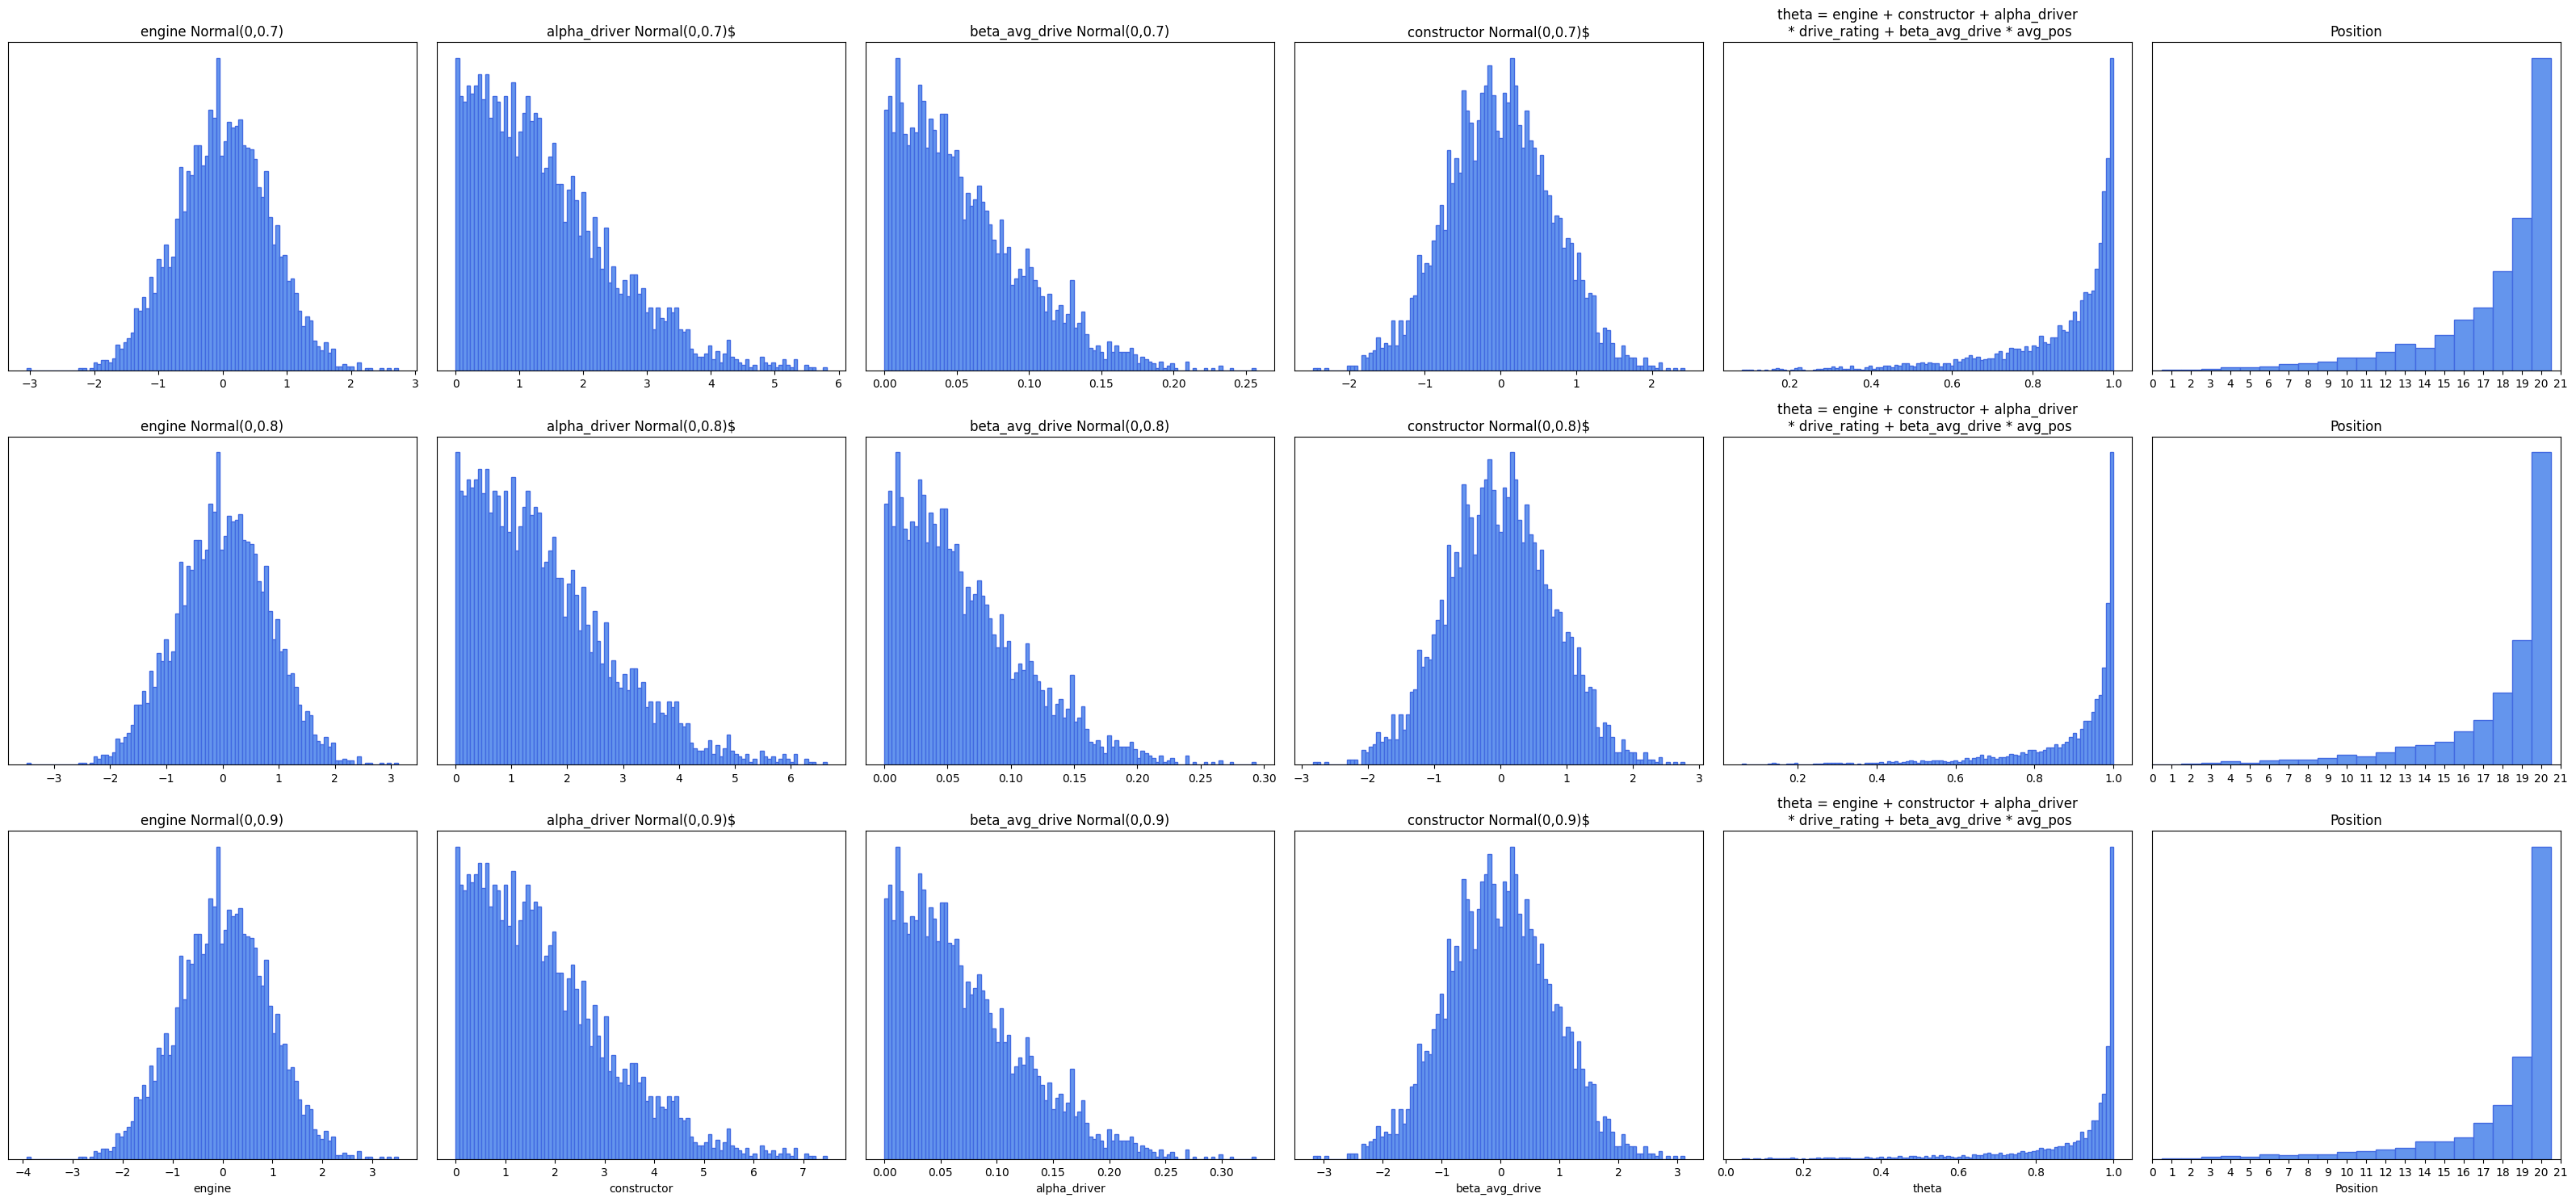

In [42]:
fig, axes = plt.subplots(3, 6, figsize=(8*4, 15))

sigmas = [0.7, 0.8, 0.9]

for s_i in range(3):
    sigma = {'sigma':sigmas[s_i], 'drive_rating': -2.5, 'avg_pos':  2.5} # Standard scaler for driver rating ang avg_pos
    model_1_ppc_sim = model_1_ppc.sample(data=sigma, iter_warmup=1, fixed_param=True, seed=10062022)
    axes[s_i, 0].hist(model_1_ppc_sim.stan_variable('engine').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 0].set_yticks([])
    axes[s_i, 0].set_title(f'engine Normal(0,{sigmas[s_i]})')


    axes[s_i, 1].hist(model_1_ppc_sim.stan_variable('alpha_driver').flatten() * 2.5, bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 1].set_yticks([])
    axes[s_i, 1].set_title(f'alpha_driver Normal(0,{sigmas[s_i]})$')

    axes[s_i, 2].hist(model_1_ppc_sim.stan_variable('beta_avg_pos').flatten() *0.1, bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 2].set_yticks([])
    axes[s_i, 2].set_title(f'beta_avg_drive Normal(0,{sigmas[s_i]})')


    axes[s_i, 3].hist(model_1_ppc_sim.stan_variable('constructor').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 3].set_yticks([])
    axes[s_i, 3].set_title(f'constructor Normal(0,{sigmas[s_i]})$')


    axes[s_i, 4].hist(model_1_ppc_sim.stan_variable('theta').flatten(), bins=100, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 4].set_yticks([])
    axes[s_i, 4].set_title(f'theta = engine + constructor + alpha_driver\n * drive_rating + beta_avg_drive * avg_pos')

    # pos_min = 1, pos_max = 20
    n_bins = np.arange(22) - 0.5
    axes[s_i, 5].hist(model_1_ppc_sim.stan_variable('y_ppc').flatten()+1, bins=n_bins, rwidth=1, color='cornflowerblue', edgecolor='royalblue', density=True)
    axes[s_i, 5].set_xticks(range(22))
    axes[s_i, 5].set_xlim([0, 21])
    axes[s_i, 5].set_yticks([])
    axes[s_i, 5].set_title('Position')

axes[2, 0].set_xlabel('engine')
axes[2, 1].set_xlabel('constructor')
axes[2, 2].set_xlabel('alpha_driver')
axes[2, 3].set_xlabel('beta_avg_drive')
axes[2, 4].set_xlabel('theta')
axes[2, 5].set_xlabel('Position')

fig.tight_layout()
plt.show()

We choose sigma 0.8 for our model

## Posterior analysis (model 2) [0-4 pts]
- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
 are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

In [48]:
model_1 = CmdStanModel(stan_file='stan/model_2.stan')

10:29:12 - cmdstanpy - INFO - compiling stan file /workspace/F1_bayesian/stan/model_2.stan to exe file /workspace/F1_bayesian/stan/model_2
10:30:06 - cmdstanpy - INFO - compiled model executable: /workspace/F1_bayesian/stan/model_2


In [55]:
df_engine = pd.read_csv('processed_data/f1_engines_all.csv')
df_rating = pd.read_csv('processed_data/f1_ratings_all.csv')
df_result = pd.read_csv('processed_data/final_results_all.csv')

In [57]:
values_only = df_engine.iloc[:, 1:]
unique_values = pd.unique(values_only.values.ravel())
unique_values = sorted(unique_values)
unique_engine_dict = {}
engine_value = []
for val, i in enumerate(unique_values):
    unique_engine_dict[val] = i
    engine_value.append(i)

{0: 'ferrari', 1: 'mercedes', 2: 'rbpt', 3: 'renault'}


In [ ]:
model_1_data = {'N': len(df_result),
                'D': len(drivers_lookup),
                'C': len(constructors_lookup),
                'driver': drivers+1,
                'constructor': constructors+1,
                'position': df['position']}

model_1_fit = model_1.sample(data=model_1_data, seed=10062022)
print(model_1_fit.diagnose())

## Model comaprison [0-4 pts]
- Have models been compared using information criteria [1 pt]
- Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]